# Сбор данных о точках интереса в окрестностях банкоматов

## Подсчет типов и количества точек интереса по переданным координатам

In [1]:
from pprint import pprint

import geopandas as gpd
import pyrosm
from cartopy.geodesic import Geodesic
from shapely.geometry import Polygon, Point

- для работы с данными OpenStreetMap используем дамп карты в границах РФ, который можно скачать по [ссылке](https://download.geofabrik.de/russia-latest.osm.pbf) со страницы сайта [https://download.geofabrik.de/russia.html](https://download.geofabrik.de/russia.html)
- очищаем дамп от ненужной нам информации при помощи утилиты [Osmium Tool](https://osmcode.org/osmium-tool/manual.html)
- для этого необходимо установить утилиту, открыть консоль, перейти в директорию с дампом и выполнить команду:
```bash
osmium tags-filter russia-latest.osm.pbf nwr/amenity nwr/building nwr/craft nwr/historic nwr/leisure nwr/office nwr/public_transport nwr/shop nwr/sport nwr/tourism -o filtered-russia.osm.pbf
```
- отфильтрованный дамп должен сохраниться в файл `filtered-russia.osm.pbf`
- уже очищенный дамп можно скачать по [ссылке](https://drive.google.com/file/d/1DiY6NZGdf8f8OekXNxYA0a45vpBG_j90/view?usp=sharing)

Создадим geopandas dataframe на основе дампа. Это процесс может занять больше 20 мин.
TODO: Придумать, как ускорить процесс загрузки датафрейма

In [2]:
osm = pyrosm.OSM("../../../datasets/filtered-russia-06-11.osm.pbf")  # Укажите путь к файлу
my_filter = {
    "amenity": True,
    "shop": True,
    "leisure": True,
    "office": True,
    "public_transport": True,
    "tourism": True,
}
russia_gpdf = osm.get_pois(
    custom_filter=my_filter
)
russia_gpdf = russia_gpdf.copy()  # Дефрагментация датафрейма

/Users/antonzajcev/code/HSE/first_year_project/atm-project/venv/lib/python3.10/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = prepare_geodataframe(
/Users/antonzajcev/code/HSE/first_year_project/atm-project/venv/lib/python3.10/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = prepare_geodataframe(
/Users/antonzajcev/code/HSE/first_year_project/atm-project/venv/lib/python3.10/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented

In [30]:
def get_poi_count_near_point(
        df: gpd.GeoDataFrame,
        point_lon: float,
        point_lat: float,
        radius: int,
        tag_types: list[str],
        plot_maps: bool = False
) -> dict[str, int]:
    """Получить количество точек интереса по типам в радиусе заданной точки.
    Описание тегов можно получить на странице https://wiki.openstreetmap.org/wiki/Map_features
    Проблема: Работает очень медленно с картой РФ (более 10 с на запрос)
    """
    gd = Geodesic()
    circle_polygon = Polygon(gd.circle(lon=point_lon, lat=point_lat, radius=radius))
    circle_gdf = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[circle_polygon])
    # аргумент predicate="intersects" позволяет учесть не только точечные объекты,
    # но и формы (например большой торговый центр), которые пересекают окружность
    # писка. Проблема - на карте могут отображаться протяженные объекты, которые
    # попали в выборку и мешать отрисовке карты в нормальном масштабе.
    # gdf_selection = gpd.sjoin(df, circle_gdf, predicate="intersects")

    # аргумент predicate="within" - учитываем только объекты внутри окружности
    # поиска. Не учитывает формы, пересекающие границу поиска.
    gdf_selection = gpd.sjoin(df, circle_gdf, predicate="within")
    tags_count_by_types = {}
    for tag_type in tag_types:
        gdf_selection[tag_type] = gdf_selection[tag_type].fillna("other_types")
        tags_count_by_types[tag_type] = dict(gdf_selection[tag_type].value_counts())
        if plot_maps:
            ax = gdf_selection.plot(
                column=tag_type, markersize=10, figsize=(16, 16), legend=True,
                legend_kwds=dict(loc="upper left", ncol=5, bbox_to_anchor=(1, 1))
            )
            ax.set_title(tag_type)
    # TODO: Необходимо переработать функцию, чтобы она возвращала только те теги,
    # которые нам нужны для анализа, предварительно группируя их по типам.
    return tags_count_by_types

In [31]:
def get_poi_count_near_point_using_r_tree(
        df: gpd.GeoDataFrame,
        point_lon: float,
        point_lat: float,
        radius: int,
        tag_types: list[str],
        plot_maps: bool = False
) -> dict[str, int]:
    """Получить количество точек интереса по типам в радиусе заданной точки.
    Используется индексирование R-tree для ускорения поиска.
    см. статью про использование  R-tree https://geoffboeing.com/2016/10/r-tree-spatial-index-python/
    Описание тегов можно получить на странице https://wiki.openstreetmap.org/wiki/Map_features
    """
    gd = Geodesic()
    circle_polygon = Polygon(gd.circle(lon=point_lon, lat=point_lat, radius=radius))

    # Быстрая фильтрация предварительных результатов с использованием R-tree index
    spatial_index = df.sindex
    possible_matches_index = list(spatial_index.intersection(circle_polygon.bounds))
    possible_matches = df.iloc[possible_matches_index]

    # Подробная фильтрация
    gdf_selection = possible_matches[possible_matches.intersects(circle_polygon)]

    tags_count_by_types = {}
    for tag_type in tag_types:
        tags_count_by_types[tag_type] = dict(gdf_selection.loc[:, tag_type].value_counts())
        if plot_maps:
            ax = gdf_selection.plot(
                column=tag_type, markersize=10, figsize=(16, 16), legend=True,
                legend_kwds=dict(loc="upper left", ncol=5, bbox_to_anchor=(1, 1))
            )
            ax.set_title(tag_type)
    # TODO: Необходимо переработать функцию, чтобы она возвращала только те теги,
    # которые нам нужны для анализа, предварительно группируя их по типам.
    return tags_count_by_types

Количество точек интереса по типам в радиусе 300 м от точки с координатами lon: 37.639096, lat: 55.765053
{'amenity': {'atm': 6,
             'bank': 5,
             'bar': 9,
             'bench': 56,
             'bicycle_parking': 24,
             'bicycle_rental': 4,
             'bureau_de_change': 1,
             'cafe': 13,
             'car_wash': 1,
             'clinic': 7,
             'community_centre': 2,
             'coworking_space': 1,
             'dentist': 2,
             'fast_food': 4,
             'fountain': 2,
             'ice_cream': 1,
             'language_school': 1,
             'library': 1,
             'money_transfer': 1,
             'music_school': 1,
             'nightclub': 2,
             'parking': 4,
             'parking_entrance': 6,
             'payment_terminal': 6,
             'pharmacy': 4,
             'place_of_worship': 2,
             'post_box': 2,
             'post_office': 6,
             'pub': 2,
             'restaurant': 

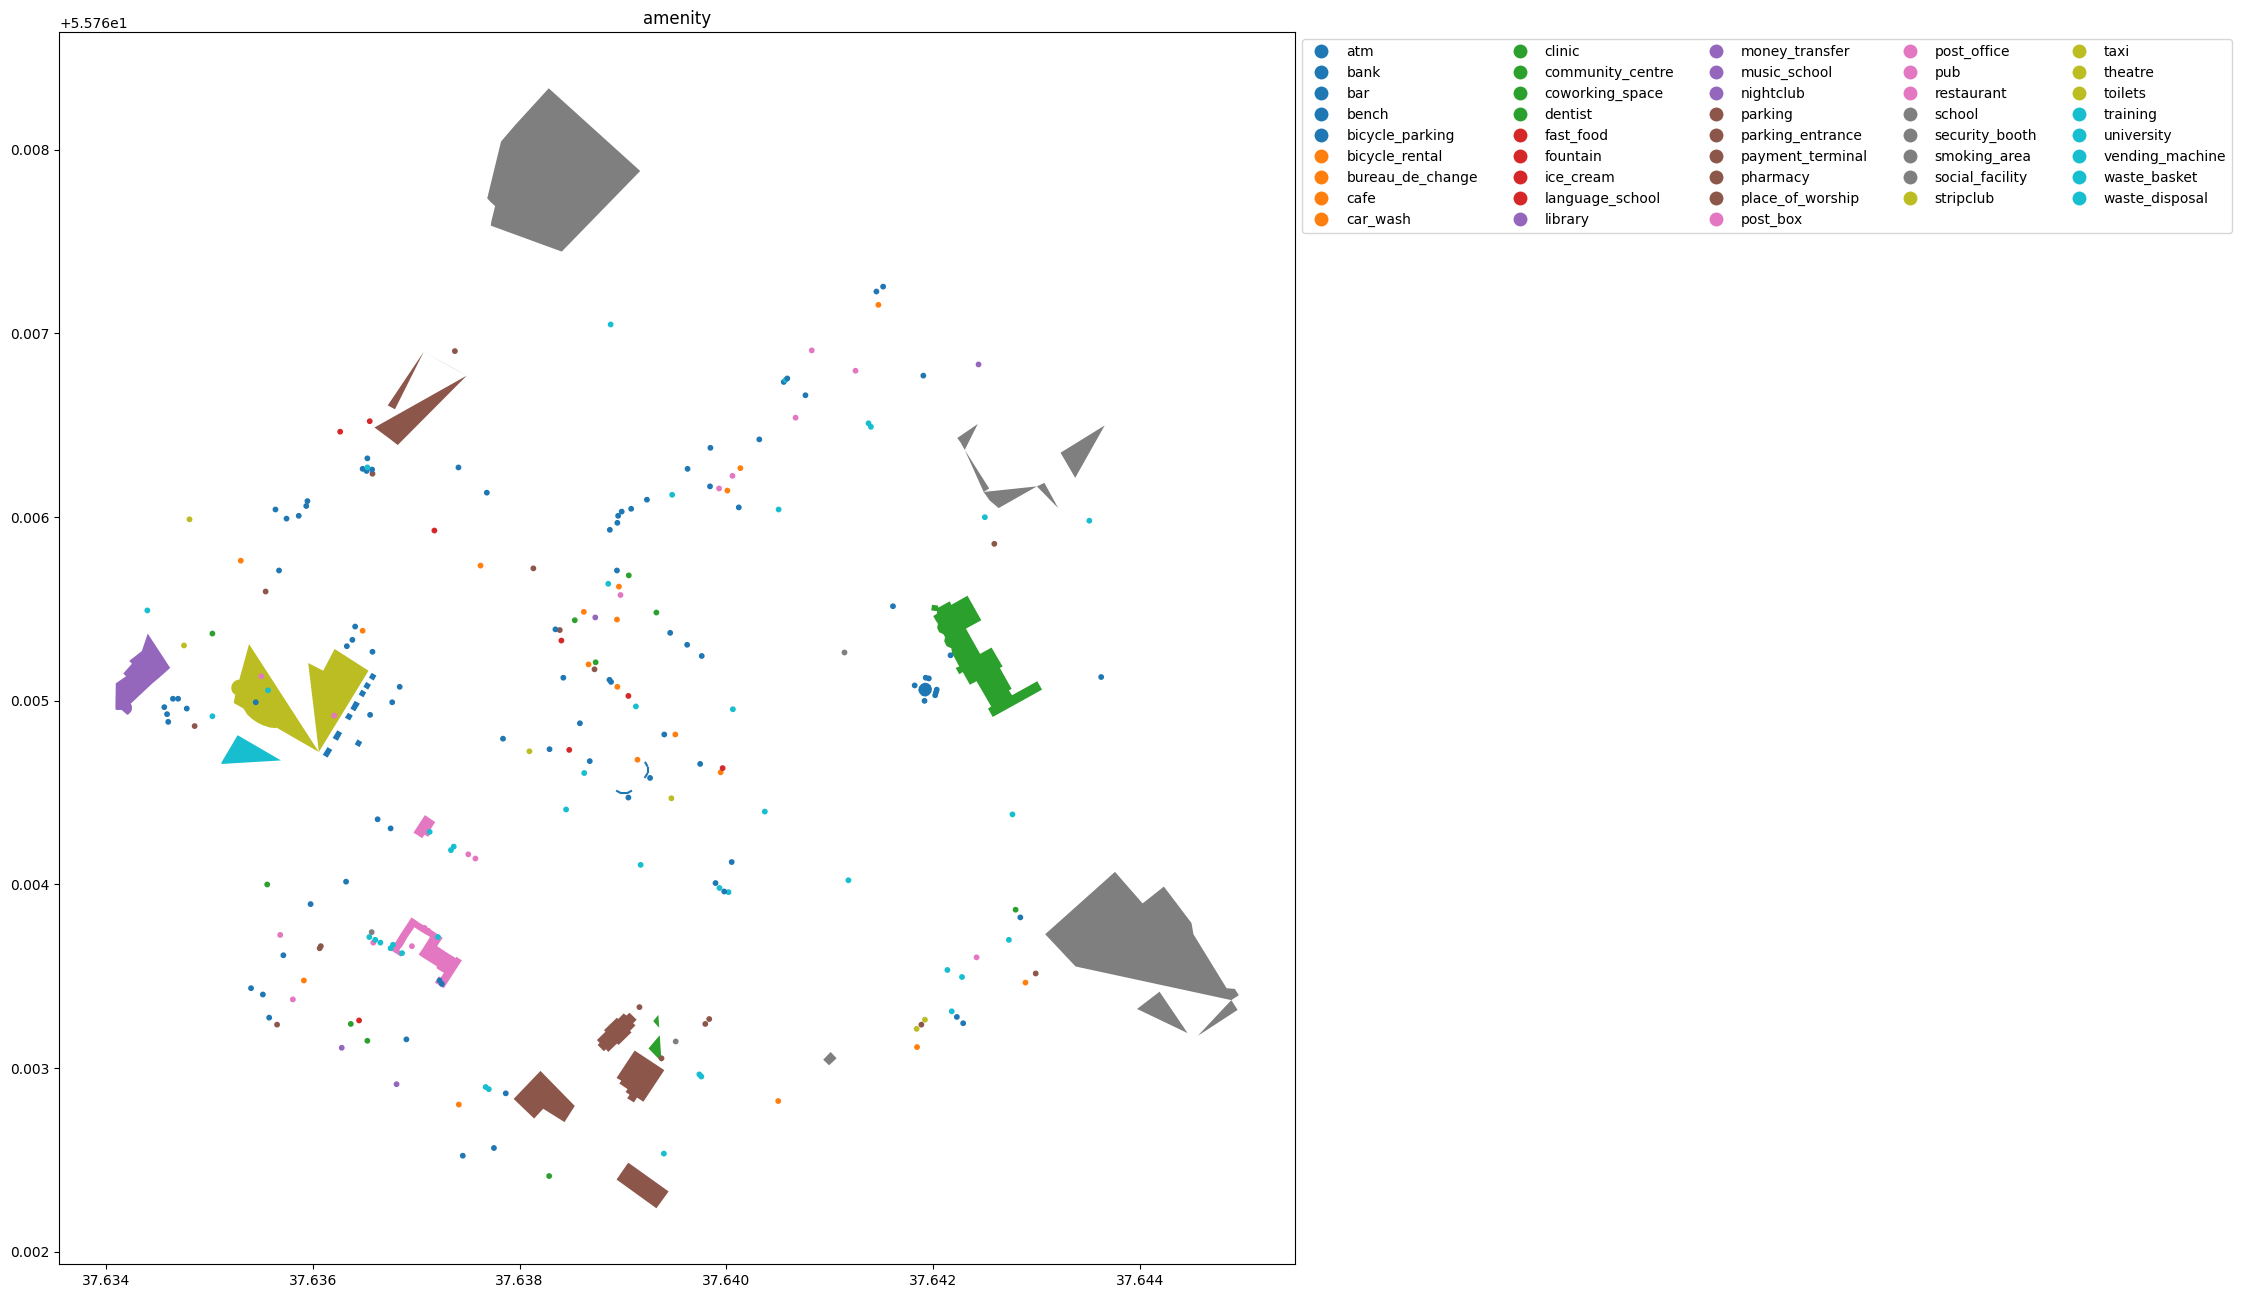

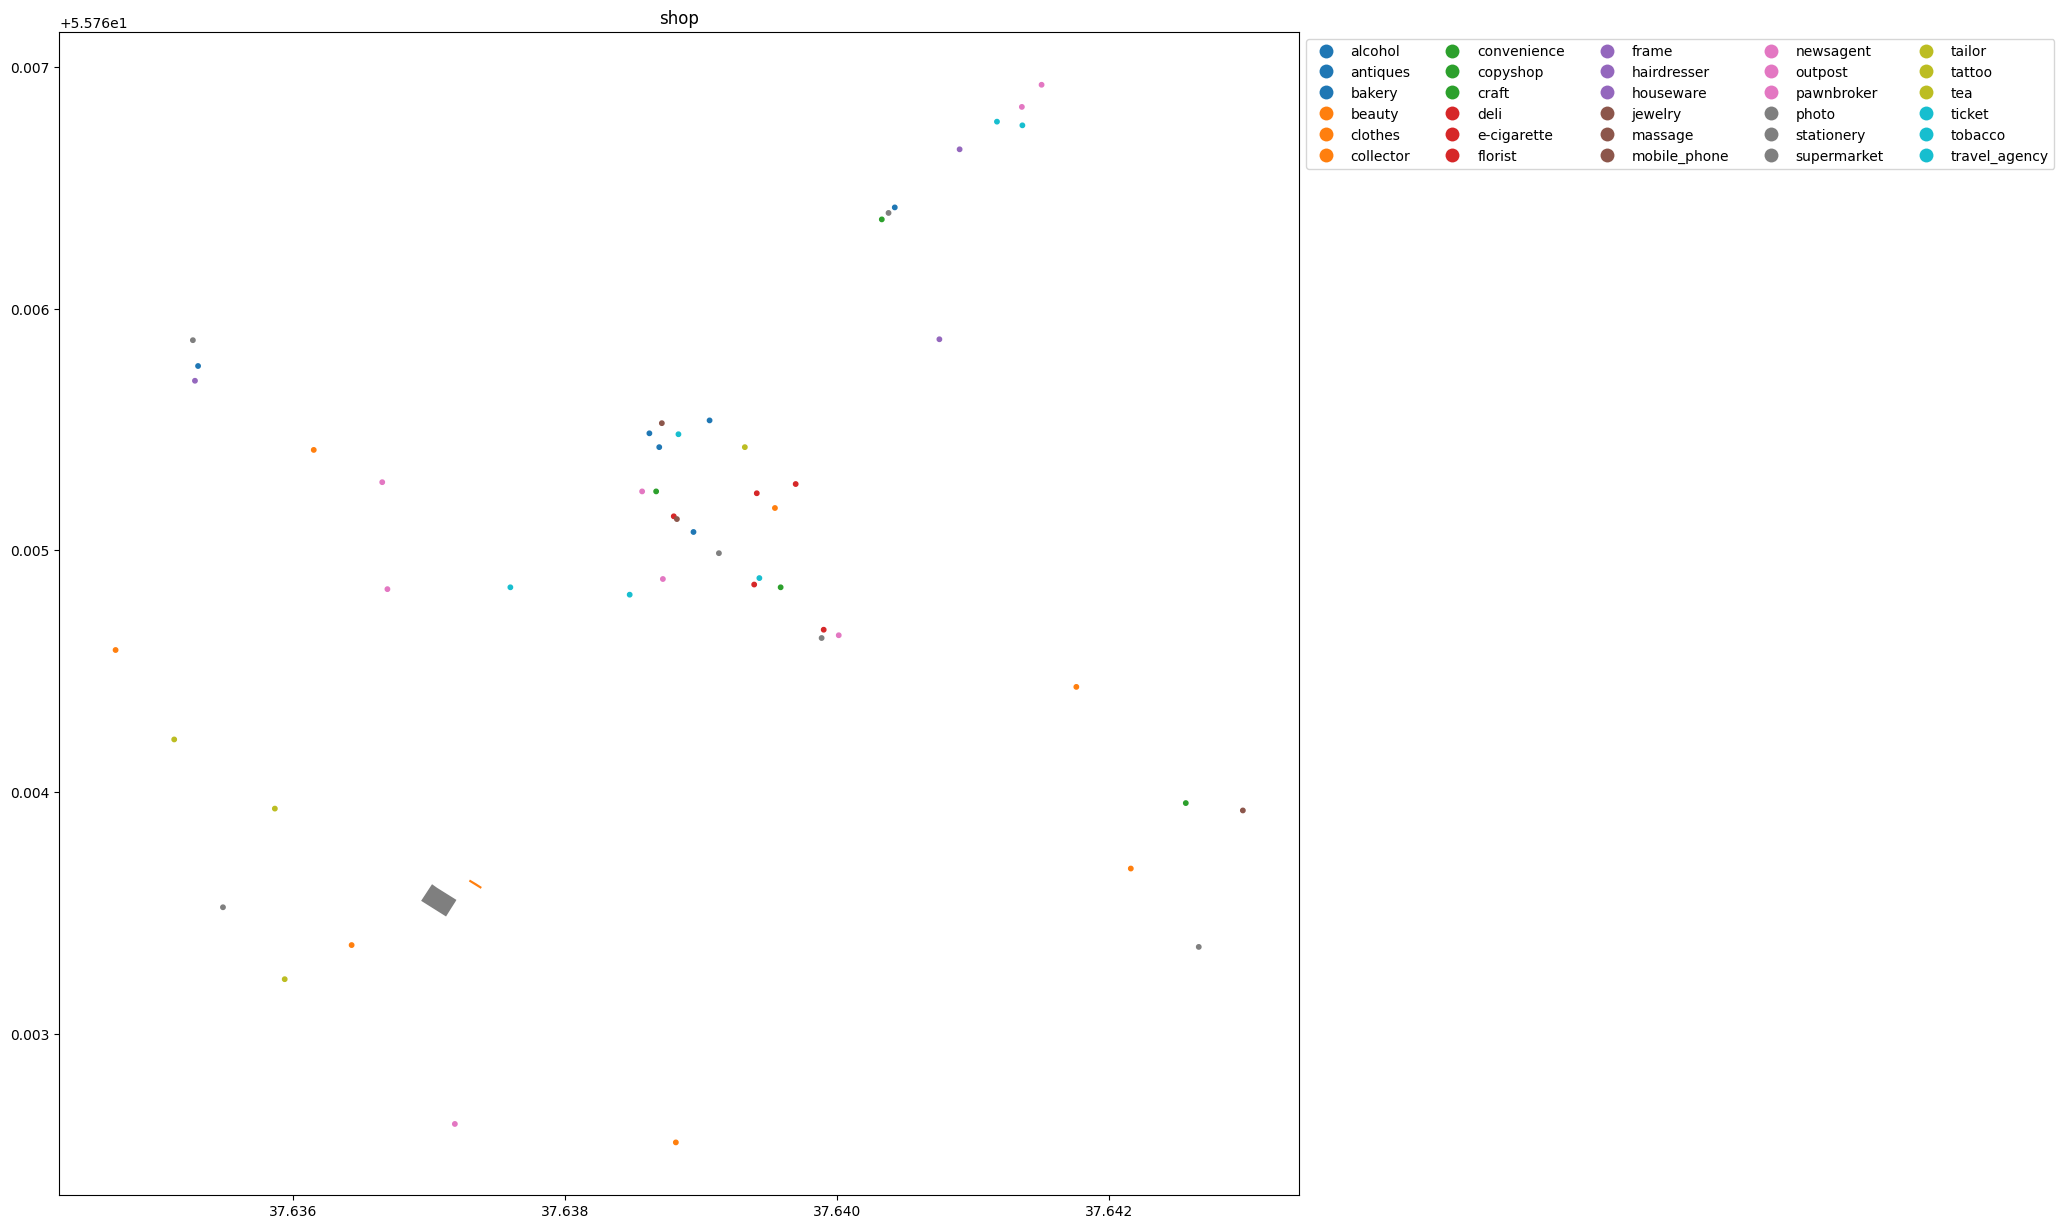

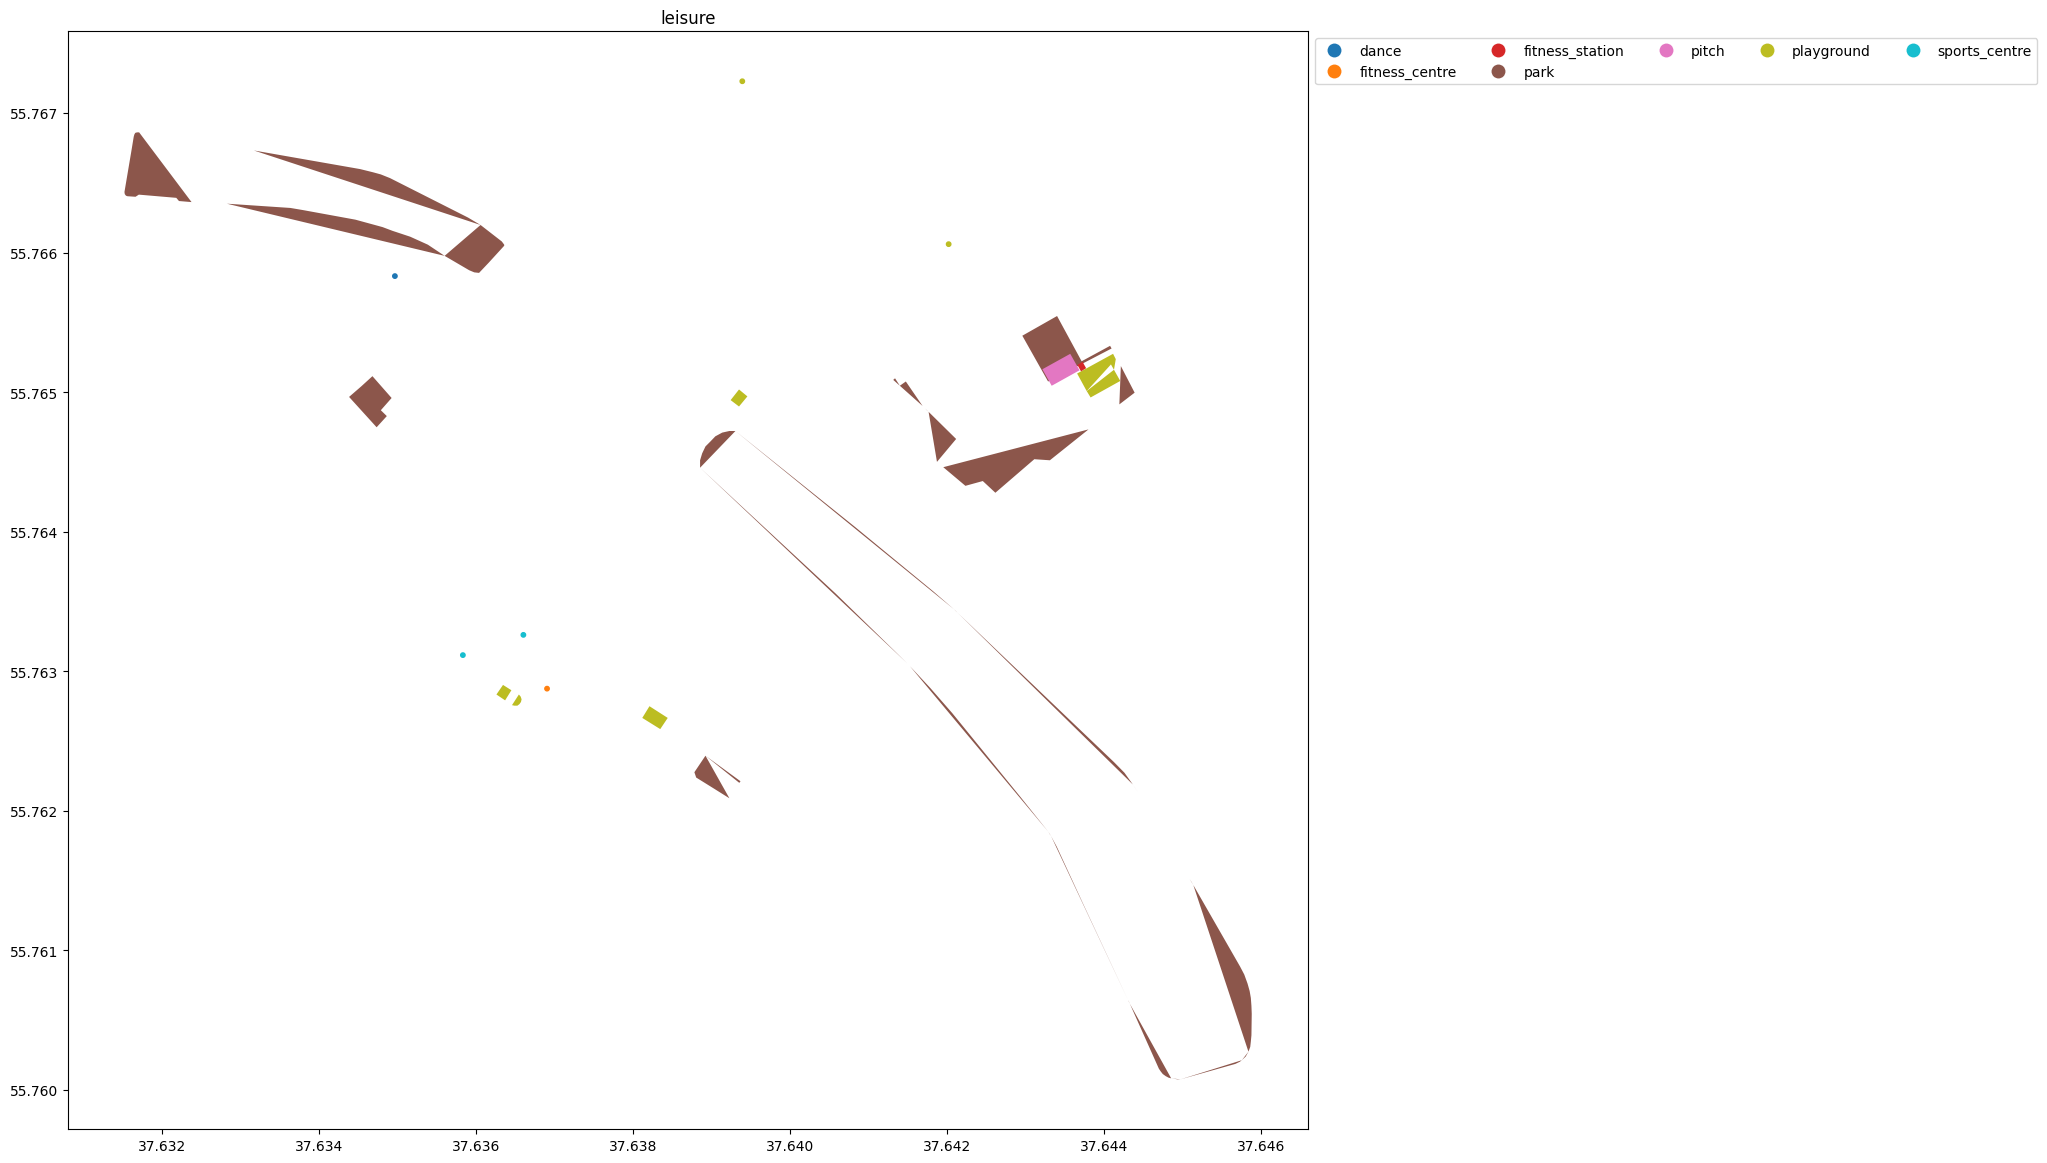

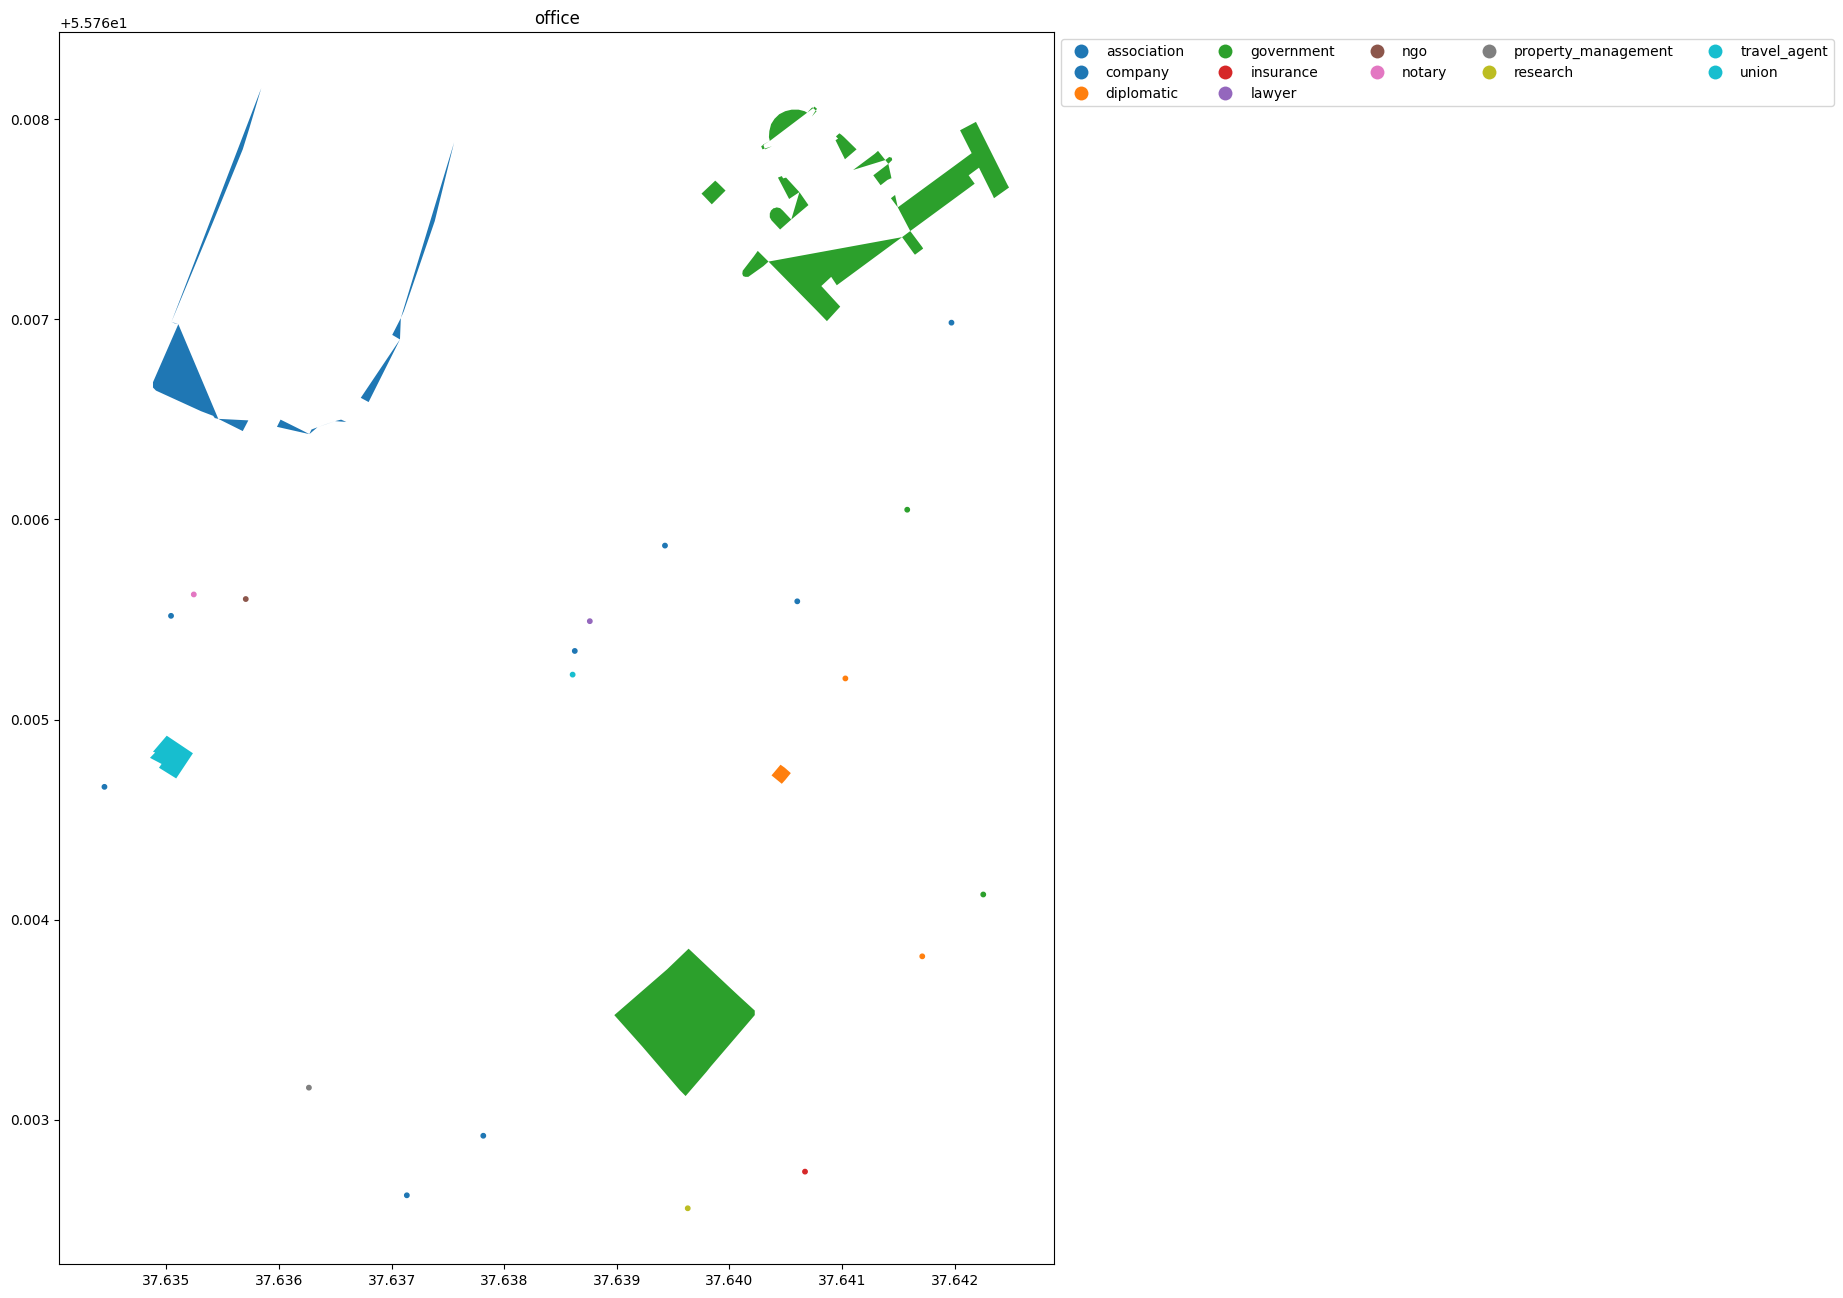

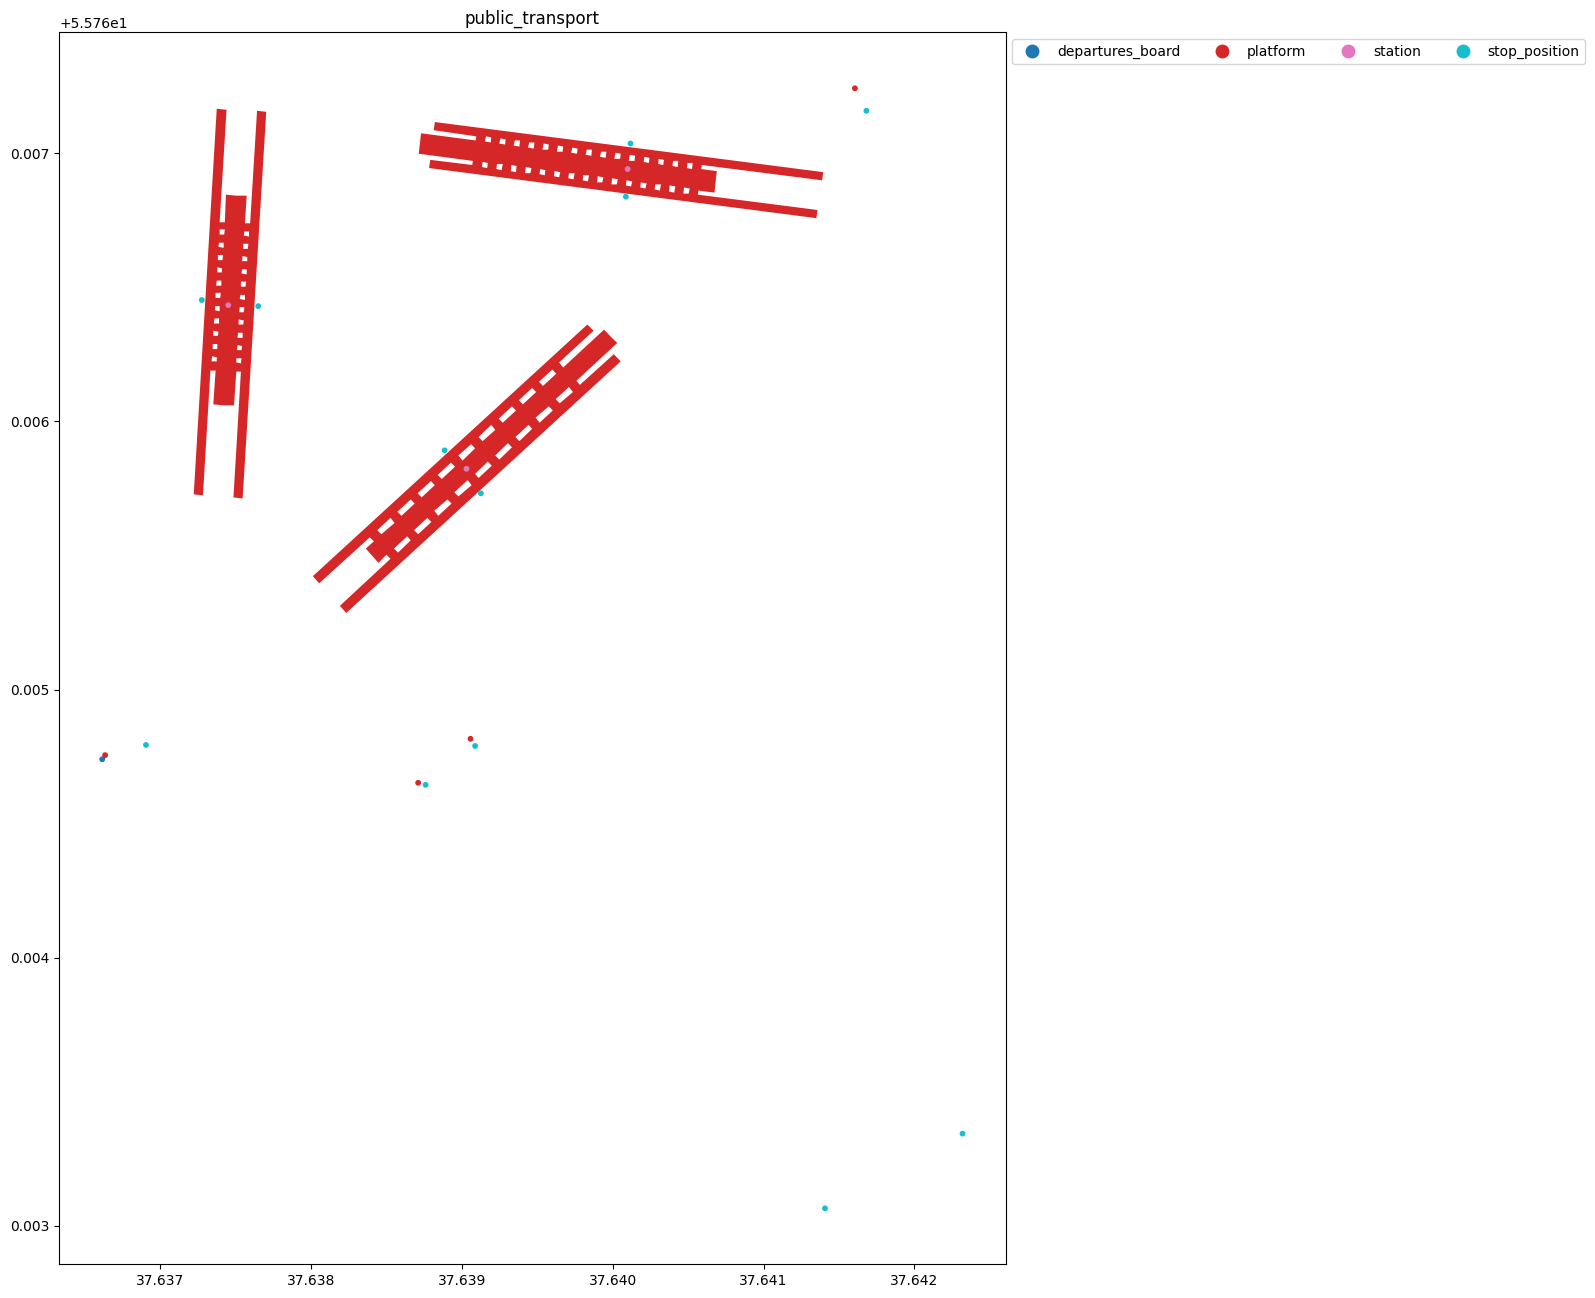

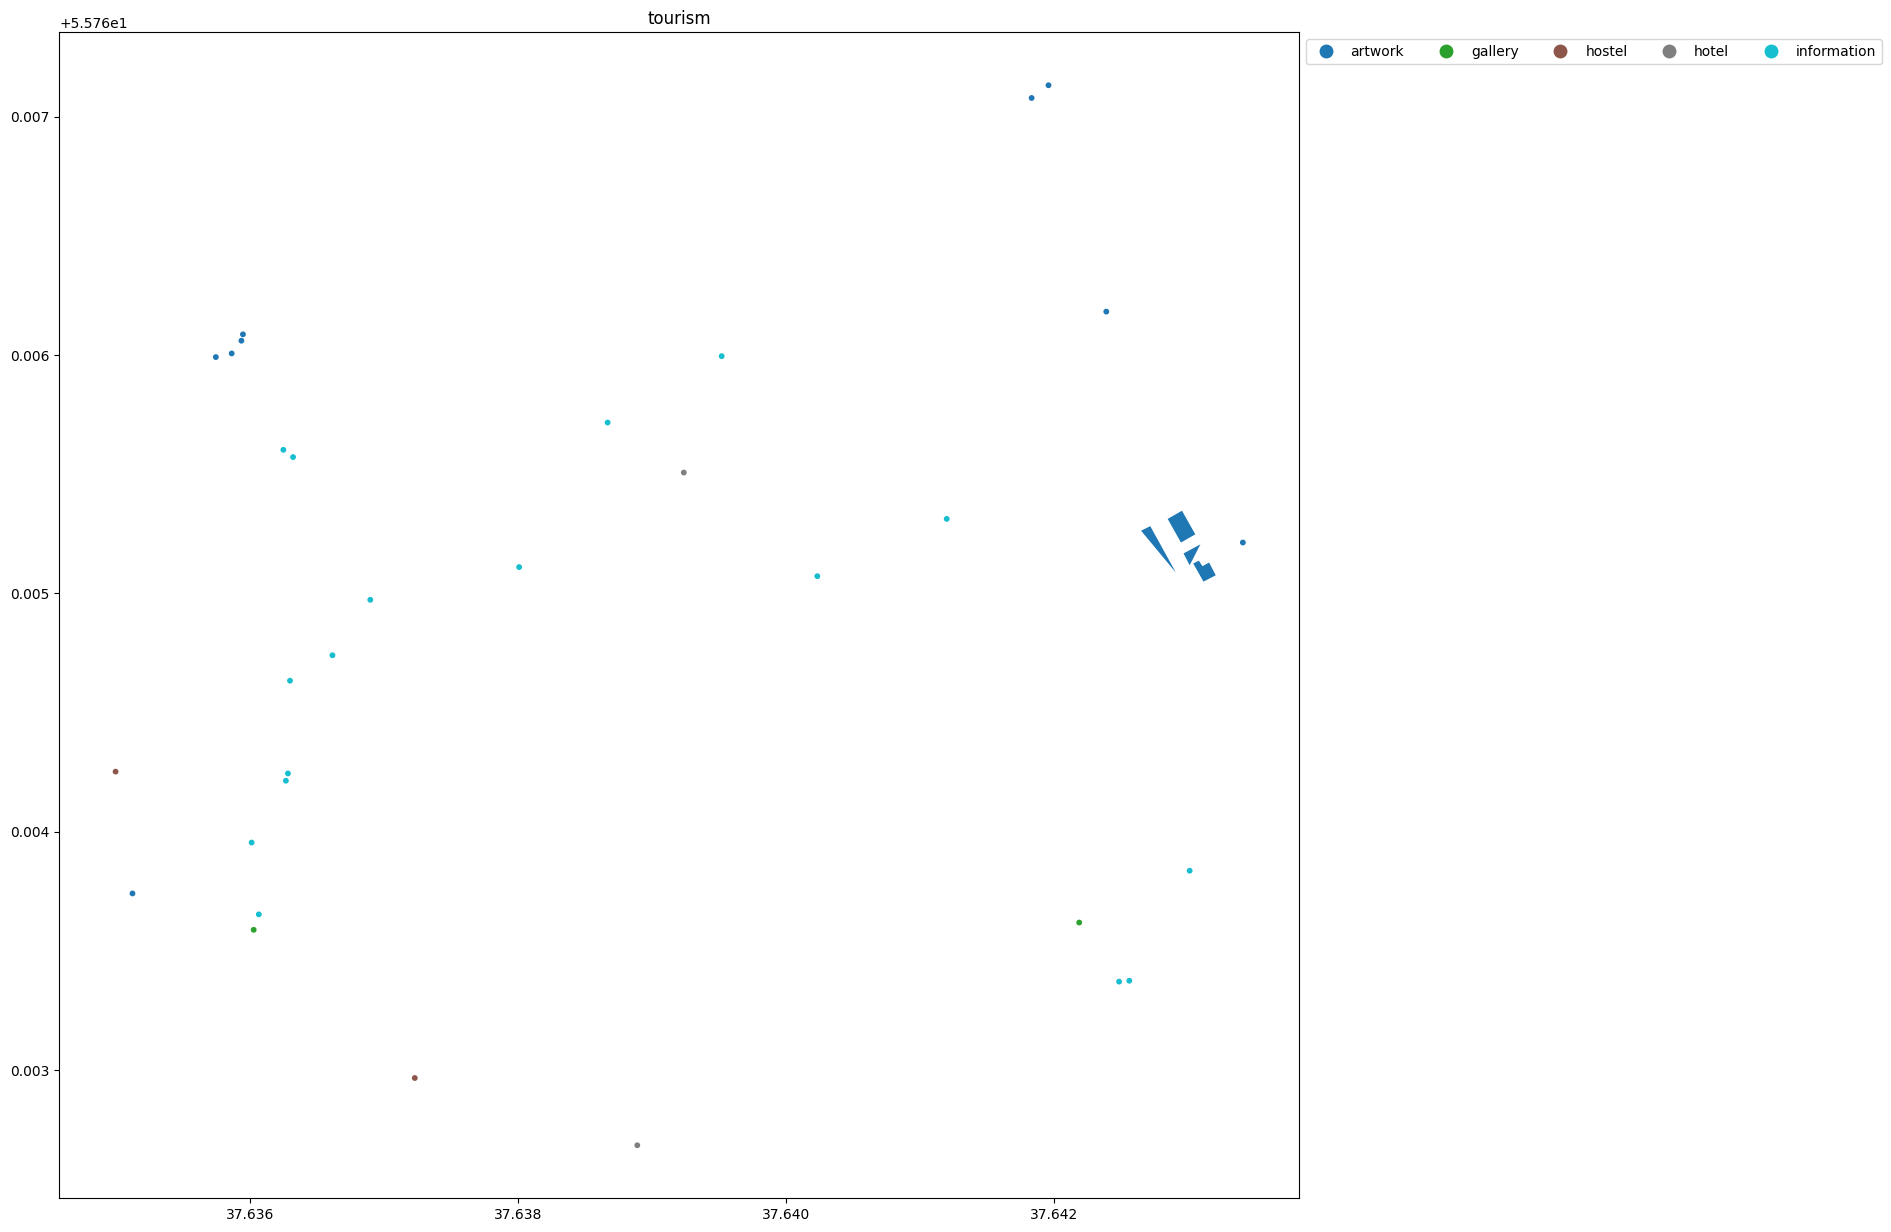

In [32]:
# Координаты адреса "Москва, Чистопрудный бульвар, 1"
lon = 37.639096
lat = 55.765053
tag_types = my_filter.keys()

searching_radius = 300 # m

poi_out = get_poi_count_near_point_using_r_tree(
    russia_gpdf, lon, lat, searching_radius, tag_types, True
)
print(f"Количество точек интереса по типам в радиусе {searching_radius} м от точки "
      f"с координатами lon: {lon}, lat: {lat}")
pprint(poi_out)


In [ ]:
# TODO: Написать скрипт для подсчета количества точек интереса для всех записей датасета ATM.
